# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# 1. Libraries & Sample Data
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

2025-09-13 23:44:04.375883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download / load Sample Data (you provided filename earlier)
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv', parse_dates=['Date'])
data = data.sort_values('Date').reset_index(drop=True)  # ensure time order
data.set_index('Date', inplace=True)

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Index data by Date
plt.figure(figsize=(12,4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

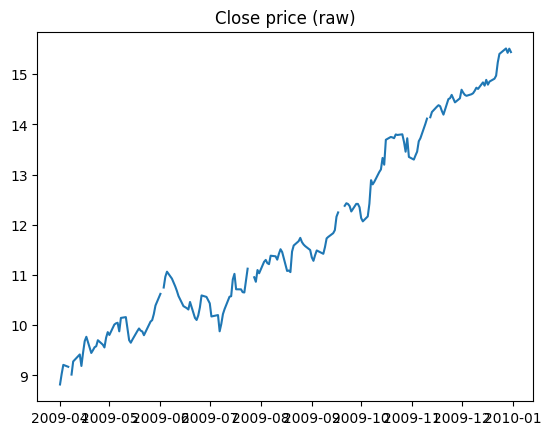

In [5]:
# Plot the Close Data
plt.plot(data['Close'])
plt.title('Close price (raw)')
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
print("\nNull counts before cleaning:\n", data.isnull().sum())
data = data.ffill().bfill()  # forward fill then backfill to be safe
print("\nNull counts after cleaning:\n", data.isnull().sum())


Null counts before cleaning:
 Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

Null counts after cleaning:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


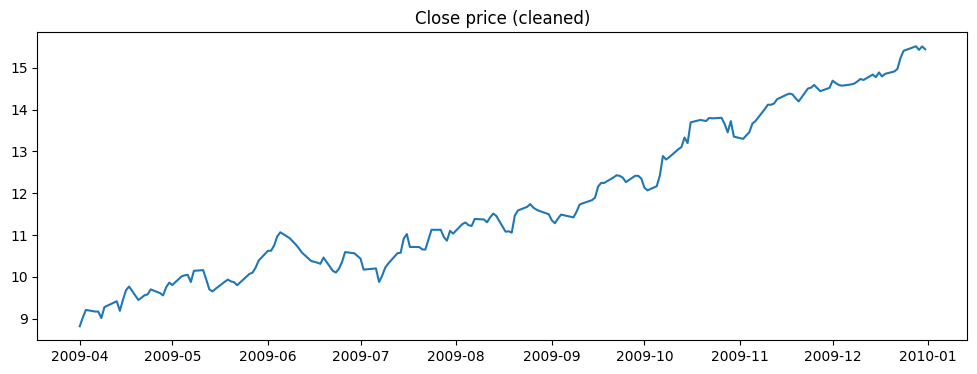

In [7]:
plt.figure(figsize=(12,4))
plt.plot(data['Close'])
plt.title('Close price (cleaned)')
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [8]:
# Calculate 20-day bollinger bands
window_bb = 20
rolling_mean = data['Close'].rolling(window_bb).mean()
rolling_std = data['Close'].rolling(window_bb).std()
bb_upper = rolling_mean + (rolling_std * 2)
bb_lower = rolling_mean - (rolling_std * 2)

data['BB_upper'] = bb_upper
data['BB_lower'] = bb_lower

In [9]:
# Remove rows with NaN bollinger bands
data = data.dropna(subset=['BB_upper', 'BB_lower']).copy()

In [10]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'BB_upper', 'BB_lower']].copy()
dataset.index.name = 'Date'
print("\nPrepared dataset head:")
display_df(dataset.head())


Prepared dataset head:


,Close,BB_upper,BB_lower
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

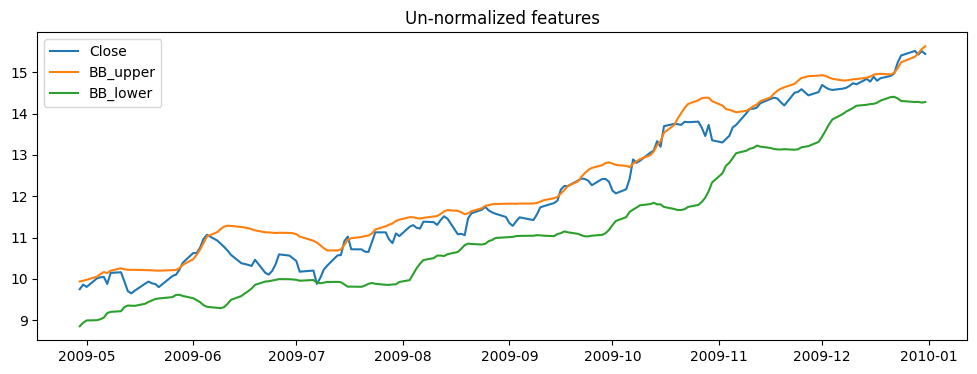

In [11]:
# Display & Plot Un-normalized Dataset
plt.figure(figsize=(12,4))
plt.plot(dataset['Close'], label='Close')
plt.plot(dataset['BB_upper'], label='BB_upper')
plt.plot(dataset['BB_lower'], label='BB_lower')
plt.legend()
plt.title('Un-normalized features')
plt.show()


Normalized dataset head:


,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692


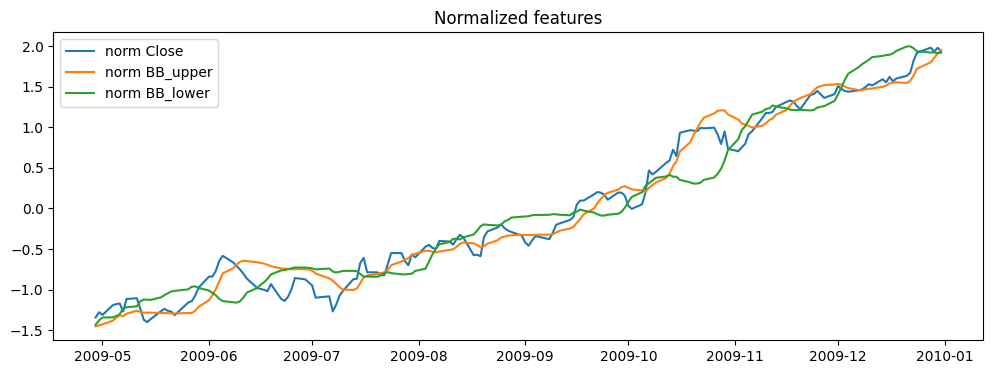

In [12]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values.astype(float)  # 2D array for scaler
    normalizer.fit(column_data)
    transformed = normalizer.transform(column_data).flatten()
    normed_dataset[col] = transformed
    normlist.append(normalizer)  # store scaler for later inverse_transform

print("\nNormalized dataset head:")
display_df(normed_dataset.head())

plt.figure(figsize=(12,4))
plt.plot(normed_dataset['Close'], label='norm Close')
plt.plot(normed_dataset['BB_upper'], label='norm BB_upper')
plt.plot(normed_dataset['BB_lower'], label='norm BB_lower')
plt.legend()
plt.title('Normalized features')
plt.show()


# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [13]:
# split dataset df into train (50%) and test (50%) datasets

split = int(len(normed_dataset) * 0.5)
train_df = normed_dataset.iloc[:split].copy()
test_df = normed_dataset.iloc[split:].copy()

In [14]:
# display train and test dfs (ensure no overlap)
print(f"Train rows: {train_df.shape[0]}, Test rows: {test_df.shape[0]}, Total: {len(normed_dataset)}")
display_df(train_df.head())
display_df(test_df.head())

Train rows: 86, Test rows: 86, Total: 172


,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692


,Close,BB_upper,BB_lower
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844


In [15]:
# convert to numpy arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

# track index to remember which feature is which
# order: Close, BB_upper, BB_lower
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

X_train shape: (86, 3) X_test shape: (86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [20]:
@keras.saving.register_keras_serializable()
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        # define layers
        self.d1 = keras.layers.Dense(64, activation='relu', input_shape=(state_size,))
        self.d2 = keras.layers.Dense(32, activation='relu')
        self.d3 = keras.layers.Dense(8, activation='relu')
        self.out = keras.layers.Dense(action_size, activation='linear')

        # build model by calling it once
        x = keras.Input(shape=(state_size,))
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        y = self.out(y)
        model = keras.Model(inputs=x, outputs=y)

        # compile
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='mse')
        self.model = model  # attach compiled model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [21]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = window_size * num_features
        self.action_size = 3  # hold, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # load or initialize model
        if test_mode and model_name:
            self.model = keras.models.load_model(model_name)
        else:
            self.model = DQN(self.state_size, self.action_size).model

    def _model(self):
        return self.model

    def get_q_values_for_state(self, state):
        # state should be shape (state_size,) or (1,state_size)
        arr = np.asarray(state).flatten().reshape(1, self.state_size)
        q = self.model.predict(arr, verbose=0)
        return q.flatten()

    def fit_model(self, input_state, target_output):
        X = np.asarray(input_state).flatten().reshape(1, self.state_size)
        y = np.asarray(target_output).reshape(1, self.action_size)
        history = self.model.fit(X, y, epochs=1, verbose=0)
        return history

    def act(self, state):
        # epsilon-greedy
        if (not self.test_mode) and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.get_q_values_for_state(state)
        return int(np.argmax(q_values))

    def exp_replay(self, batch_size):
        losses = []
        if len(self.memory) == 0:
            return losses
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            # predicted Q for current state
            target_q = self.get_q_values_for_state(state)
            if done:
                optimal_q_for_action = reward
            else:
                q_next = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.max(q_next)
            # update target q for the action taken
            target_q[action] = optimal_q_for_action
            # fit model on (state -> target_q)
            history = self.fit_model(state, target_q)
            # history.history['loss'] is a list with single element since epochs=1
            losses.extend(history.history.get('loss', []))

        # epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [22]:
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    # stable sigmoid for arrays
    return 1 / (1 + np.exp(-np.array(x)))

def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        idxs = train_df.index.values
        step = max(1, int(len(idxs)/15))
        plt.xticks(range(0, len(idxs), step), idxs[0::step], rotation=45, fontsize='small')
    else:
        idxs = test_df.index.values
        step = max(1, int(len(idxs)/15))
        plt.xticks(range(0, len(idxs), step), idxs[0::step], rotation=45, fontsize='small')
    plt.show()

def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()


In [23]:
# returns an n-day state representation ending at time t
def get_state(data, t, n):
    # data is a 2D numpy array (rows = timesteps, cols = features)
    # t is the current time step index (0-based within the array)
    # n is window length (number of rows included in state)
    # produce a flattened vector of length n * num_features, using nearest available for missing early indexes
    state = []
    for i in range(n):
        idx = t - n + 1 + i
        if idx < 0:
            row = data[0]  # special case: use first row when idx negative
        else:
            row = data[idx]
        # apply sigmoid to each feature in the row
        state.append(sigmoid(row))
    state = np.array(state).flatten()
    return state


### Training Loop

In [29]:
keras.utils.disable_interactive_logging()

window_size = 1
num_features = X_train.shape[1]

agent = Agent(window_size=window_size + 1, num_features=num_features, test_mode=False, model_name='')

/opt/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running episode 1/2:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit: $8.62
Total Winners: 22
Total Losers: 2
Max Loss in this episode: 16.06793785095215
Total Loss in this episode: 448.63204351965885


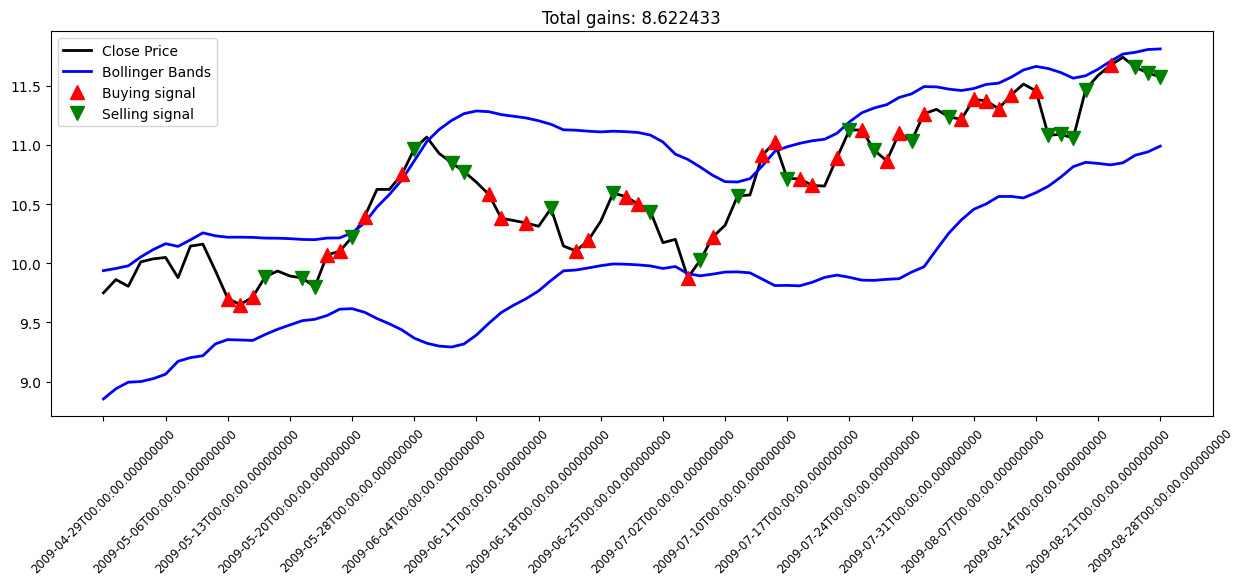

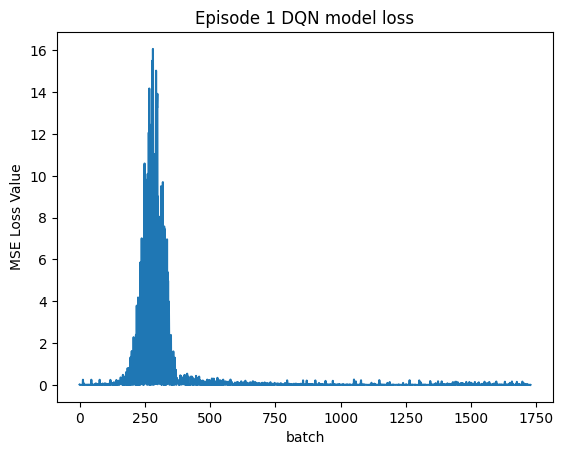

Running episode 2/2:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 2
Total Profit: $4.89
Total Winners: 18
Total Losers: 12
Max Loss in this episode: 19.281404495239258
Total Loss in this episode: 199.99434545121807


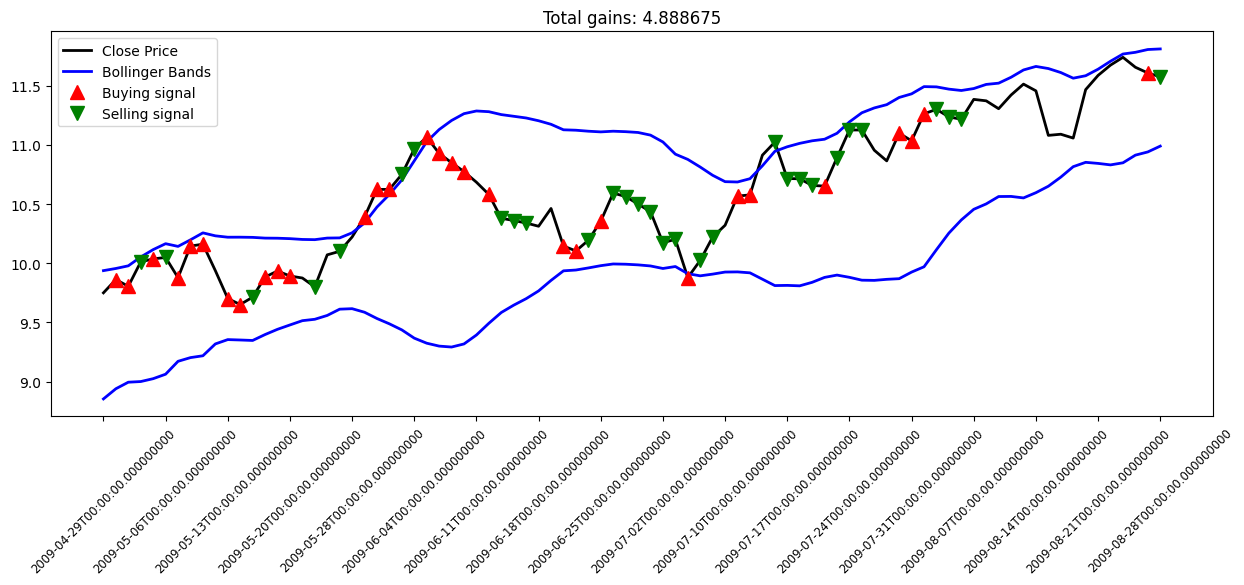

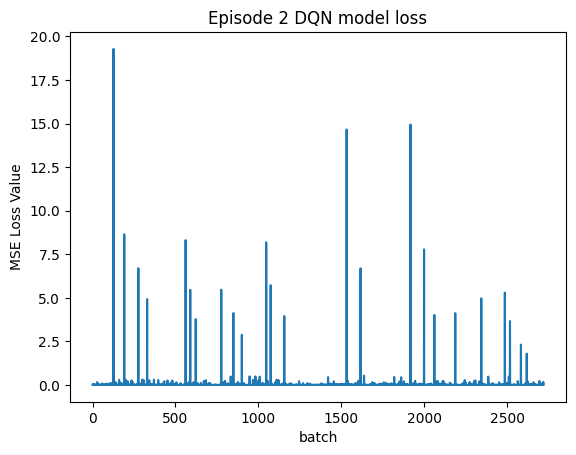

Saved model_ep2.keras


In [30]:
l = len(X_train) - 1  # number of time steps to iterate over (we use next_state hence -1 safe)
batch_size = 32
episode_count = 2  # small for demo

# pull scalers back out of normlist using dataset column order
normalizer_close = normlist[0]
normalizer_bb_upper = normlist[1]
normalizer_bb_lower = normlist[2]

# inverse transforms for plotting true prices for train set
# Note: we inverse-transform the entire column from X_train (which is normalized)
X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1,1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1,1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1,1)).flatten()

batch_losses = []
num_batches_trained = 0

# TRAINING LOOP
for e in range(1, episode_count + 1):
    # starting state: get_state on t=0 with n = window_size + 1 (as in your prompts)
    state = get_state(X_train, 0, window_size + 1)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    # iterate t over the data
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t+1, window_size + 1)  # next state's t+1
        reward = 0

        if action == 1:  # buy
            # get true buy price by inverse transforming the normalized close at time t+1
            buy_price = normalizer_close.inverse_transform(X_train[t+1, idx_close].reshape(-1,1)).flatten()[0]
            agent.inventory.append(buy_price)
            states_buy.append(t+1)
            # print action summary (optional)
            # print(f'Buy: {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0:  # sell
            bought_price = agent.inventory.pop(0)
            sell_price = normalizer_close.inverse_transform(X_train[t+1, idx_close].reshape(-1,1)).flatten()[0]
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)  # reward definition given
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += 1
            else:
                total_losers += 1
            states_sell.append(t+1)
            # print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

        # done flag for last iteration
        done = True if t == l - 1 else False

        # add experience to memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # when memory > batch_size, run experience replay to update network
        if len(agent.memory) >= batch_size:
            losses = agent.exp_replay(batch_size)
            if len(losses) > 0:
                batch_losses.extend(losses)

    # episode ended
    print('--------------------------------')
    print(f'Episode {e}')
    print(f'Total Profit: {format_price(total_profit)}')
    print(f'Total Winners: {total_winners}')
    print(f'Total Losers: {total_losers}')
    if len(batch_losses) > num_batches_trained:
        print(f'Max Loss in this episode: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
        print(f'Total Loss in this episode: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
        plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit, train=True)
        plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
        num_batches_trained = len(batch_losses)

        # save model checkpoint every 2 episodes (as requested)
        if e % 2 == 0:
            agent.model.save(f'model_ep{e}.keras')
            print(f"Saved model_ep{e}.keras")

### Plot Training Loss

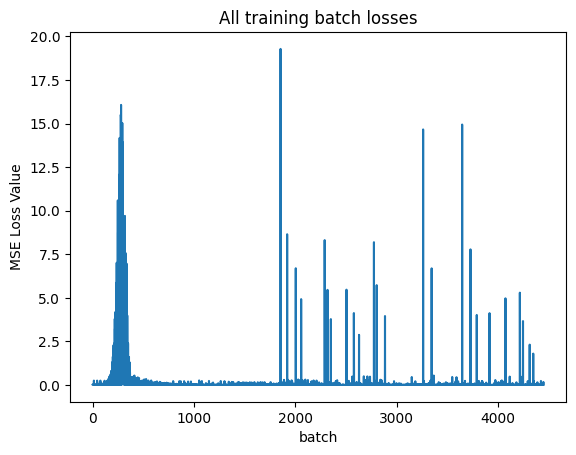

In [31]:
# use the plot_losses function to plot all batch_losses for the entire training round
# plot full training losses
if len(batch_losses) > 0:
    plot_losses(batch_losses, "All training batch losses")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [32]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Load the trained model (use last saved episode)
agent_test = Agent(window_size=window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent_test.inventory = []

state = get_state(X_test, 0, window_size + 1)

# True (inverse transformed) test series for plotting
X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1,1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1,1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1,1)).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

In [35]:
for t in range(l_test):
    action = agent_test.act(state)
    next_state = get_state(X_test, t+1, window_size + 1)
    reward = 0

    if action == 1:  # buy
        buy_price = normalizer_close.inverse_transform(X_test[t+1, idx_close].reshape(-1,1)).flatten()[0]
        agent_test.inventory.append(buy_price)
        states_buy_test.append(t+1)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent_test.inventory) > 0:  # sell
        bought_price = agent_test.inventory.pop(0)
        sell_price = normalizer_close.inverse_transform(X_test[t+1, idx_close].reshape(-1,1)).flatten()[0]
        trade_profit = sell_price - bought_price
        reward = max(trade_profit, 0)
        total_profit += trade_profit
        states_sell_test.append(t+1)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

    if t == l_test - 1:
        done = True

    # append to memory (for potential later fine-tuning)
    agent_test.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit (test): {format_price(total_profit)}')
        print('------------------------------------------')

plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)

ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 6), found shape=(1, 3)